In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import signature.tensor_algebra as ta
from simulation.diffusion import Diffusion

import matplotlib
my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + jnp.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"])

## Goal: Model stationary path-dependence

Our goal is to develop a tool for which would allow us efficiently treat general stationary path-dependent models. By a **stationary path-dependence** we will understand the dependence
$$
S_t = F((X_s)_{-\infty < s \leq t}),
$$
such that 
\begin{equation}
    F((x_s)_{-\infty < s \leq t}) = F((x_{s - h})_{-\infty < s \leq t + h}).
\end{equation}
This means that $S_t$ depends only on the past path of $X$, but not on the time variable $t$ itself.


##### Generating the underlying Brownian motion:

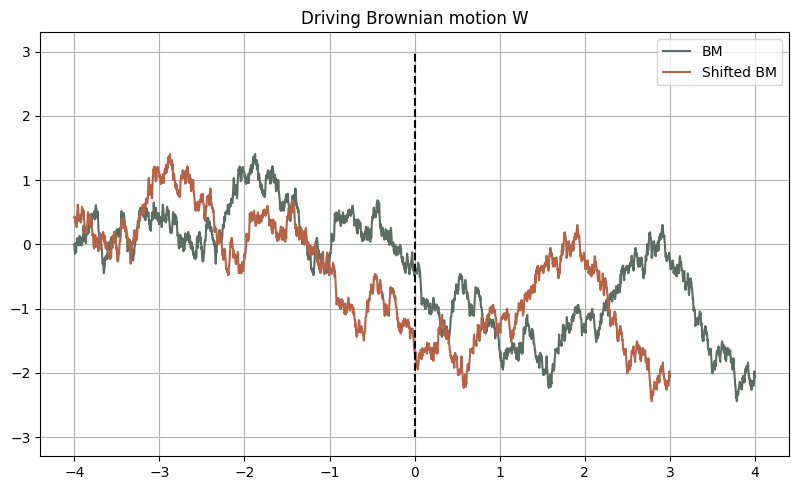

In [2]:
T = 4

t_grid = jnp.linspace(-T, T, (T * 2) * 365 + 1)
rng = np.random.default_rng(seed=4843) # 50 ; 123
size = 10

diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]

fig, ax = plt.subplots()

shift = 365
ax.plot(t_grid, W, label="BM")
ax.plot(t_grid[:-shift], W[shift:], label="Shifted BM")
ax.vlines(0, -3, 3, "k", ls='--')
ax.legend()
ax.set_title("Driving Brownian motion W")

fig.tight_layout()
# fig.savefig("shifted_signal.pdf", format="pdf", transparent=True)

We denote the shifted (green) trajectory by $\widetilde W = (W_{t +1})_{t \in \mathbb{R}}$.

The condition of stationary path-dependence implies that $F((\widetilde W)_{s \leq 3}) = F((W)_{s \leq 4})$.

### Stationary Signature definition

The stationarity assumption is natural for many applications. However, it cannot be applied to the standard signature models. Indeed, the definition  of $\mathbb{X}_t$ can be seen as a Taylor expansion of path in the neighborhood of the time origin $t = 0$. 
- The presence of this time origin $t_0 = 0$ makes the stationaryty condition inapplicable due to the finiteness and variability of its length $t$. 
- Hence, it is natural to suppose that at time $t$, the path is observable from infinitely distant time $-\infty$ to $t$.

For the integrals to be defined, we damp the integrators $\circ dX_u$ by $e^{-\lambda(t - u)}$ for some positive $\lambda > 0$:

$$
	\mathbb{X}^{\lambda, n}_{t}= \int_{-\infty < u_{1} < \ldots < u_{n} < t}^{}  e^{ -\lambda(t-u_{1}) }\otimes \circ dX_{u_{1}} \ldots e^{ -\lambda(t-u_{n}) }\otimes \circ dX_{u_{n}} 
$$

The **stationary signature** is then given by $\mathbb{X}^{\lambda}_{t} = \left(\mathbb{X}^{\lambda, n}_{t}\right)_{n \geq 0}.$

Similarly, we can define
$$
	\mathbb{X}^{\lambda, n}_{s, t}= \int_{s < u_{1} < \ldots < u_{n} < t}^{}  e^{ -\lambda(t-u_{1}) }\otimes \circ dX_{u_{1}} \ldots e^{ -\lambda(t-u_{n}) }\otimes \circ dX_{u_{n}} 
$$
and $\mathbb{X}^{\lambda}_{s, t} = \left(\mathbb{X}^{\lambda, n}_{s, t}\right)_{n \geq 0}.$

### Computing the stationary signature for $\hat W_t = (t, W_t)$

- It is important to observe the signal for $t < 0$ for the signature on $[0, T]$ to be stationary.
- In practice, we take the path on $[T_0, T]$ for some $T_0 < 0$, compute the stationary signature $\widehat{\mathbb{W}}^{\lambda}_{t}$ and keep its values only for $t > 0$.

In [5]:
t_grid_pos = t_grid[t_grid >= 0]
W_pos = W[t_grid >= 0]

path_3d = np.vstack([t_grid, W, W]).T
path = np.vstack([t_grid, W]).T
path_pos = np.vstack([t_grid_pos, W_pos]).T
dim = path.shape[1]

In [6]:
%%time
N = 10
N_3d = 5
Sig = ta.path_to_signature(path=path_pos, trunc=N)

CPU times: user 20.6 ms, sys: 7.95 ms, total: 28.5 ms
Wall time: 27.8 ms


In [7]:
%%time
lam = jnp.array([5, 5])
SigS = ta.path_to_fm_signature(path=path, trunc=N, t_grid=t_grid, lam=lam)

CPU times: user 3.94 s, sys: 117 ms, total: 4.06 s
Wall time: 3.98 s


In [8]:
%%time
lam_3d = jnp.array([4, 10, 2])
SigS_3d = ta.path_to_fm_signature(path=path_3d, trunc=N_3d, t_grid=t_grid, lam=lam_3d)

CPU times: user 2.06 s, sys: 51.9 ms, total: 2.11 s
Wall time: 2.06 s


### Some nice properties

- The words ${\color{NavyBlue}{\mathbf{2}}}^{\otimes k}$ correspond to $\frac{Y_{t}^{k}}{k!}$, where $Y$ is a stationary OU process defined by $Y_{t} = \int_{-\infty}^{t} e^{ -\lambda(t-s) } \, dW_{s}$.
-  The words ${\color{NavyBlue}{\mathbf{1}}}^{\otimes k}$ correspond to constants $\frac{\lambda^{-k}}{k!}$.
-  The words ${\color{NavyBlue}{\mathbf{21} ... \mathbf{1}}}$ can be interpreted as an exponential moving averages of $Y$ with different coefficients $k\lambda$.

In [9]:
# Define some basic words
e = ta.AlgebraBasis(trunc=N, dim=2)
e_3d = ta.AlgebraBasis(trunc=N_3d, dim=3)

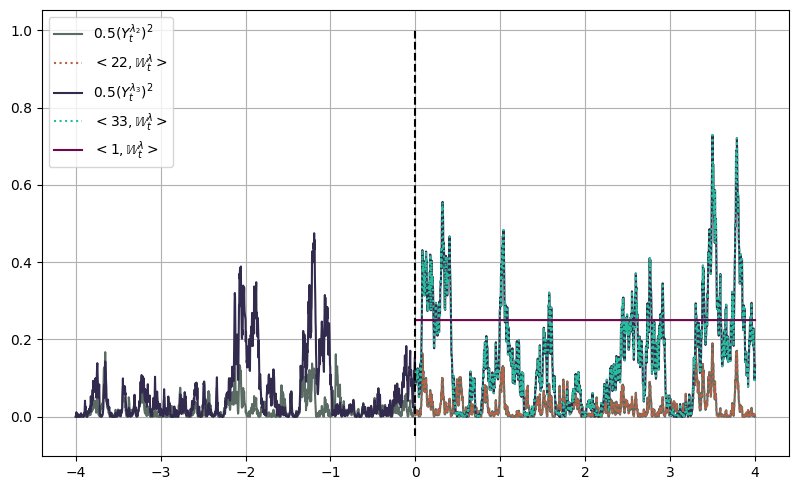

In [10]:
ou_1 = diffusion.ornstein_uhlenbeck(lam=float(lam_3d[1]), theta=0, sigma=1)[0, 0, :]
ou_2 = diffusion.ornstein_uhlenbeck(lam=float(lam_3d[2]), theta=0, sigma=1)[0, 0, :]

fig, ax = plt.subplots()
ax.plot(t_grid, ou_1**2 / 2, label="$0.5 (Y_t^{\lambda_2})^2$")
ax.plot(t_grid_pos, e_3d[22] @ SigS_3d, ":", label="$<22, {\mathbb{W}}_{t}^{\lambda}>$")

ax.plot(t_grid, ou_2**2 / 2, label="$0.5 (Y_t^{\lambda_3})^2$")
ax.plot(t_grid_pos, e_3d[33] @ SigS_3d, ":", label="$<33, {\mathbb{W}}_{t}^{\lambda}>$")

ax.plot(t_grid_pos, e_3d[1] @ SigS_3d, label="$<1, {\mathbb{W}}_{t}^{\lambda}>$")
ax.legend()
ax.vlines(0, -0.05, 1., "k", ls='--')

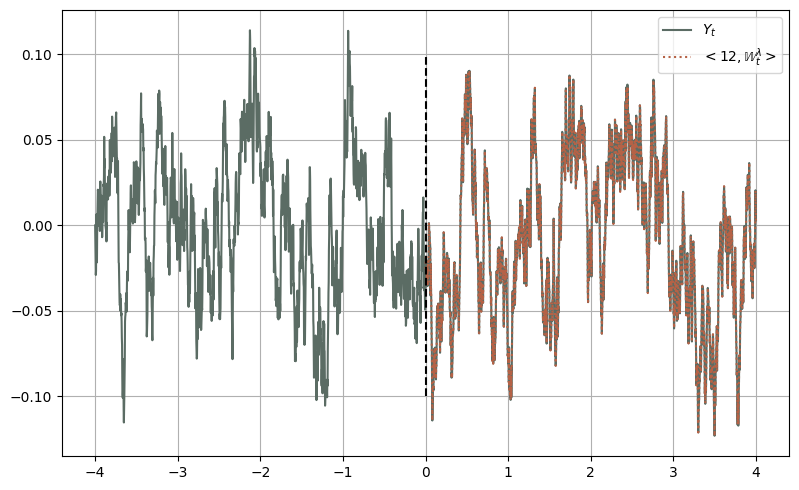

In [11]:
ou_2 = diffusion.ornstein_uhlenbeck(lam=float(lam[0] + lam[1]), theta=0, sigma=1)[0, 0, :]

fig, ax = plt.subplots()
ax.plot(t_grid, ou_2 / lam[0], label="$Y_t$")
ax.plot(t_grid_pos, e[12] @ SigS, ":", label="$<12, {\mathbb{W}}_{t}^{\lambda}>$")
ax.legend()
ax.vlines(0, -0.1, 0.1, "k", ls='--')

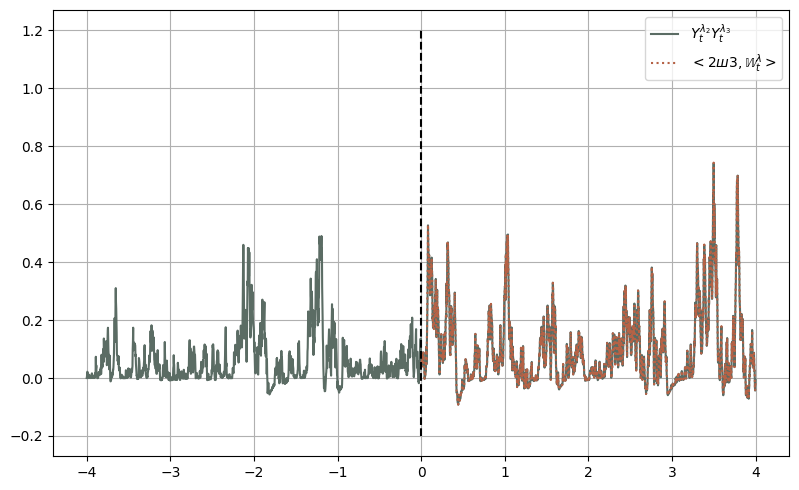

In [12]:
shuffle_table = ta.get_shuffle_table(dim=3, table_trunc=N_3d)
ou_1 = diffusion.ornstein_uhlenbeck(lam=float(lam_3d[1]), theta=0, sigma=1)[0, 0, :]
ou_2 = diffusion.ornstein_uhlenbeck(lam=float(lam_3d[2]), theta=0, sigma=1)[0, 0, :]

fig, ax = plt.subplots()
ax.plot(t_grid, ou_2 * ou_1, label="$Y_t^{\lambda_2}Y_t^{\lambda_3}$")
ax.plot(t_grid_pos, ta.shuffle_prod(e_3d[2], e_3d[3], shuffle_table=shuffle_table) @ SigS_3d, ":", label="$<2ш3, {\mathbb{W}}_{t}^{\lambda}>$")
ax.legend()
ax.vlines(0, -0.2, 1.2, "k", ls='--')

### More properties


An operator $\mathcal{G}\colon T((\mathbb{R}^d)) \to T((\mathbb{R}^d))$ is defined by 
$$
\mathcal{G}\colon \boldsymbol{\ell} = (\boldsymbol{\ell}^n)_{n\geq 0} \mapsto \mathcal{G}\boldsymbol{\ell} = (n\boldsymbol{\ell}^n)_{n\geq 0}.
$$

For $\lambda > 0$ and $h \geq 0$, we define an operator $\mathcal{D}_h^\lambda$ by
\begin{align}
    \mathcal{D}_h^\lambda \colon\ & T((\mathbb{R}^d)) \to T((\mathbb{R}^d)) \\
    & \boldsymbol{\ell} = (\boldsymbol{\ell}^n)_{n \geq 0} \mapsto \mathcal{D}_h^\lambda \boldsymbol{\ell} = (e^{-n\lambda h}\boldsymbol{\ell}^n)_{n \geq 0}.
\end{align}

- Stationary signature satisfies the following SDE: $$
    d\mathbb{X}^{\lambda}_{t} = -\lambda \mathcal{G} \mathbb{X}^{\lambda}_{t}\,dt + \mathbb{X}^{\lambda}_{t}\otimes\circ dX_t.$$
- Chen's identity: $$ \mathbb{X}^{\lambda}_{s, t} = \mathcal{D}_{t - u}^\lambda\mathbb{X}^{\lambda}_{s, u} \otimes \mathbb{X}^{\lambda}_{u, t}.$$
- Shuffle property: $$\left\langle{ \boldsymbol{\ell},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle \left\langle{ \boldsymbol{\psi},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle =\left\langle{ \boldsymbol{\ell}\mathrel{\sqcup \mkern -3.2mu \sqcup} \boldsymbol{\psi},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle.$$
- Expected signature $\mathcal{E}^\lambda = \mathbb{E}\mathbb{X}^{\lambda}_{t}$ can be calculated explicitly, $\mathcal{E}_t^\lambda = \mathbb{E}\mathbb{X}^{\lambda}_{0, t}$ can be computed as a solution of ODE.

### Regression of coefficients

We want to estimate $\boldsymbol{\ell}$ observing a signal $S$, which is supposed to be a linear combination
$$S_t = \left\langle{ \boldsymbol{\ell},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle$$

As an example, we consider $S_t = \sin(Z_t)$, where 
$$
dZ_t = \kappa (\theta - Z_t) dt + \nu dW_t,
$$
and do the linear regression of $S_t$ against $\mathbb{W}_{t}^{\lambda}$.

Text(0.5, 1.0, 'Signal')

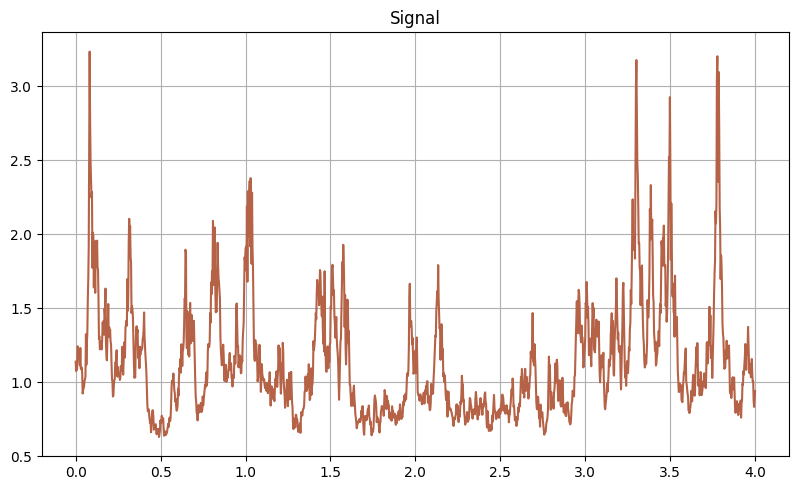

In [13]:
kappa = 15
theta = 0.
nu = 1.5

rng = np.random.default_rng(seed=4843)
diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)

ou_mu = diffusion.ornstein_uhlenbeck(lam=kappa, theta=theta, sigma=nu)[0, 0, :]
signal = 1 / (1.01 + np.sin(ou_mu)[t_grid >= 0])

fig, ax = plt.subplots()
ax.plot(t_grid_pos, signal, color=my_copper)
ax.set_title("Signal")

In [14]:
lam = jnp.array([1, 1]) * 10
SigS = ta.path_to_fm_signature(path=path, trunc=N, t_grid=t_grid, lam=lam)

In [14]:
trunc = 3
dim = 2

trunc_stat = 5
dim_stat = 2

n_params = int(ta.number_of_words_up_to_trunc(trunc, dim))
n_params_stat = int(ta.number_of_words_up_to_trunc(trunc_stat, dim_stat))

eps_sig = 5e-5
eps_sigs = 0

in_sample_T = 1
in_sample_idx = (t_grid_pos <= in_sample_T)

def loss_vol_sig(l):
    vol_coef = ta.from_array(array=l, trunc=N, dim=dim)
    return np.mean((signal - Sig @ vol_coef)[in_sample_idx]**2) + eps_sig * np.sum(np.abs(l))

def loss_vol_stat_sig(l):
    vol_coef = ta.from_array(array=l, trunc=N, dim=dim_stat)
    return np.mean((signal - SigS @ vol_coef)[in_sample_idx]**2) + eps_sigs * np.sum(np.abs(l))

l0 = jnp.zeros(n_params)
l0_stat = jnp.zeros(n_params_stat)

In [15]:
%%time
res = minimize(fun=loss_vol_sig, x0=l0)

CPU times: user 3.34 s, sys: 22.5 ms, total: 3.36 s
Wall time: 3.37 s


In [16]:
%%time
res_stat = minimize(fun=loss_vol_stat_sig, x0=l0)

CPU times: user 1.23 s, sys: 4.44 ms, total: 1.23 s
Wall time: 1.23 s


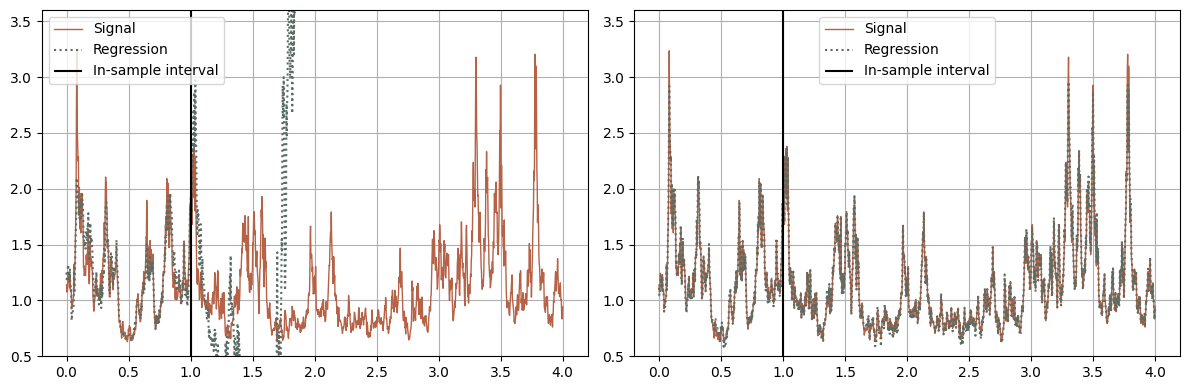

In [17]:
l_reg = ta.from_array(array=res.x, trunc=N, dim=dim)
l_reg_stat = ta.from_array(array=res_stat.x, trunc=N, dim=dim_stat)

lim_a = 0.5
lim_b = 3.6

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_grid_pos, signal, color=my_copper, lw=1, label="Signal")
ax[0].plot(t_grid_pos, Sig @ l_reg, ":", color=my_green,  label="Regression")
ax[0].vlines(x=in_sample_T, ymin=lim_a, ymax=lim_b, color="k", label="In-sample interval")
ax[0].set_ylim([lim_a, lim_b])
#ax[0].set_title("Signature regression")
ax[0].legend()

ax[1].plot(t_grid_pos, signal, color=my_copper, lw=1, label="Signal")
ax[1].plot(t_grid_pos, SigS @ l_reg_stat, ":", color=my_green, label="Regression")
ax[1].vlines(x=in_sample_T, ymin=lim_a, ymax=lim_b, color="k", label="In-sample interval")
ax[1].set_ylim([lim_a, lim_b])
#ax[1].set_title("Stationary Signature regression")
ax[1].legend()

fig.tight_layout()
# fig.savefig("signature_regression.pdf", format="pdf", transparent=True)

#### Observations
- Signature regression does not work well out-of-sample because of it non-stationarity and explosive behavior when $t \to \infty$.
- Signature regression overfits thanks to the non-stationary features, regularization is needed to improve its performance. Stationary signature works well without regulatisation.

### Prediction of signal

Using the Chen's identity and the expected signature, one can compute the conditionally expectations and variances:
\begin{equation}
        \mathbb{E}[S_{t+h} \,|\, \mathbb{F}_t] = \left\langle \boldsymbol{\ell}, \mathcal{D}_h^\lambda\widehat{\mathbb{W}}^{\lambda}_{t}\otimes\mathcal{E}_{h}\right\rangle, \quad \mathbb{V}\mathrm{ar}[S_{t+h} \,|\, \mathbb{F}_t] = \left\langle \boldsymbol{\ell}^{\mathrel{\sqcup \mkern -3.2mu \sqcup} 2}, \mathcal{D}_h^\lambda\widehat{\mathbb{W}}^{\lambda}_{t}\otimes\mathcal{E}_{h}\right\rangle - \left\langle \boldsymbol{\ell}, \mathcal{D}_h^\lambda\widehat{\mathbb{W}}^{\lambda}_{t}\otimes\mathcal{E}_{h}\right\rangle^2.
\end{equation}

In [18]:
%%time

dt = jnp.diff(t_grid_pos)[0]
eSigS_dt = ta.expected_bm_stationary_signature(trunc=N, lam=lam, t=dt)

CPU times: user 1.66 s, sys: 40.9 ms, total: 1.7 s
Wall time: 1.69 s


In [19]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=2)

In [20]:
# TODO: calculate pred signature as time-dependent signature

t_grid_pred = t_grid_pos[t_grid_pos > in_sample_T]

t0_idx = jnp.where(t_grid_pos <= in_sample_T)[0][-1]
t = t_grid_pos[t0_idx]
SigS_t = SigS.subsequence(jnp.array([t0_idx]))

signal_pred = jnp.zeros_like(t_grid_pred)
signal_pred_std = jnp.zeros_like(t_grid_pred)
l_reg_stat_sq = ta.shuffle_pow(l_reg_stat, 2, shuffle_table=shuffle_table)
for i in range(t_grid_pred.size):
    SigS_t = ta.tensor_prod(ta.D(SigS_t, dt, lam), eSigS_dt)
    signal_pred = signal_pred.at[i].set(SigS_t @ l_reg_stat)
    signal_pred_std = signal_pred_std.at[i].set(np.sqrt(SigS_t @ l_reg_stat_sq - signal_pred[i]**2))

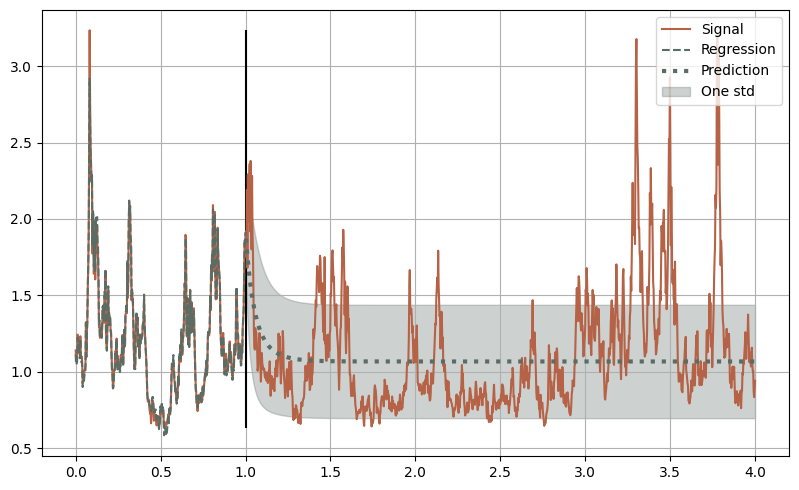

In [21]:
fig, ax = plt.subplots()
ax.vlines(x=in_sample_T, ymin=np.min(signal), ymax=np.max(signal), color="k")
ax.plot(t_grid_pos, signal, color=my_copper, label="Signal")
ax.plot(t_grid_pos[t_grid_pos <= in_sample_T], (SigS @ l_reg_stat).real[t_grid_pos <= in_sample_T], "--", color=my_green, label="Regression")
ax.plot(t_grid_pred, signal_pred, ":", color=my_green, label="Prediction", lw=3)
ax.fill_between(t_grid_pred, signal_pred - signal_pred_std, signal_pred + signal_pred_std, color=my_green, alpha=0.3, label="One std")
# ax.set_title("Prediction of signal given $\mathcal{F}_t$")
ax.legend(loc=1)

fig.tight_layout()
fig.savefig("signature_prediction.pdf", format="pdf", transparent=True)